In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

## 1. karate dataset
- Zachary's karate club is a social network of a university karate club, described in the paper "An Information Flow Model for Conflict and Fission in Small Groups" by Wayne W. Zachary. The network became a popular example of community structure in networks after its use by Michelle Girvan and Mark Newman in 2002

In [137]:
import numpy as np

# this dataset has 34 nodes

node_list = np.arange(34)
edge_list = np.array([(1, 0), (2, 0), (2, 1), (3, 0), (3, 1), (3, 2),
                 (4, 0), (5, 0), (6, 0), (6, 4), (6, 5), (7, 0), (7, 1),
                 (7, 2), (7, 3), (8, 0), (8, 2), (9, 2), (10, 0), (10, 4),
                 (10, 5), (11, 0), (12, 0), (12, 3), (13, 0), (13, 1), (13, 2),
                 (13, 3), (16, 5), (16, 6), (17, 0), (17, 1), (19, 0), (19, 1),
                 (21, 0), (21, 1), (25, 23), (25, 24), (27, 2), (27, 23),
                 (27, 24), (28, 2), (29, 23), (29, 26), (30, 1), (30, 8),
                 (31, 0), (31, 24), (31, 25), (31, 28), (32, 2), (32, 8),
                 (32, 14), (32, 15), (32, 18), (32, 20), (32, 22), (32, 23),
                 (32, 29), (32, 30), (32, 31), (33, 8), (33, 9), (33, 13),
                 (33, 14), (33, 15), (33, 18), (33, 19), (33, 20), (33, 22),
                 (33, 23), (33, 26), (33, 27), (33, 28), (33, 29), (33, 30),
                 (33, 31), (33, 32)])
        

In [138]:
# the same labeling as https://arxiv.org/abs/1609.02907 and https://arxiv.org/abs/1403.6652
class1 = [4, 6, 5, 10, 16]
class2 = [2, 9, 24, 25, 27, 28, 31]
class3 = [0, 1, 3, 7, 11, 12, 13, 17, 19, 21]
class4 = [8, 14, 15, 18, 20, 22, 23, 26, 29, 30, 32, 33]

node_color, Label = [], []
for i in range(34):
    if i in class1:
        node_color.append('red'); Label.append(0)
    elif i in class2:
        node_color.append('blue'); Label.append(1)
    elif i in class3:
        node_color.append('green'); Label.append(2)
    else:
        node_color.append('purple'); Label.append(3)
        
Label = torch.LongTensor(Label)

### train/test split

In [139]:
train_nodes = torch.LongTensor([2, 3, 4, 8, 9, 10, 11, 14])
test_nodes = torch.LongTensor([ 0,  1,  5,  6,  7, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
       25, 26, 27, 28, 29, 30, 31, 32, 33])

print (Label[train_nodes])
print (Label[test_nodes])

tensor([1, 2, 0, 3, 1, 0, 2, 3])
tensor([2, 2, 0, 0, 2, 2, 2, 3, 0, 2, 3, 2, 3, 2, 3, 3, 1, 1, 3, 1, 1, 3, 3, 1,
        3, 3])


### obtain the adjacency matrix

In [140]:
# random walk normalization of A

A = np.zeros((34, 34))
A[edge_list[:, 0], edge_list[:, 1]] = 1
A[edge_list[:, 1], edge_list[:, 0]] = 1

A = A + np.eye(34)
D = np.diag(A.sum(1))
A = np.linalg.inv(D + 1e-8) @ A
A = torch.FloatTensor(A)

In [141]:
# initial node features
X = torch.eye(34)
X

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

## 2. GCN

In [208]:
class GraphConvolutionLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super(GraphConvolutionLayer, self).__init__()
        self.transform = nn.Linear(in_features, out_features)

    def forward(self, adjacency_matrix, input_features):
        # apply the adjacency matrix first
        adj_X = adjacency_matrix @ input_features
        output = self.transform(adj_X)
        return output

class GCN(nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes):
        super(GCN, self).__init__()
        # define two graph covolutional layers
        self.layer1 = GraphConvolutionLayer(num_features, hidden_dim)
        self.layer2 = GraphConvolutionLayer(hidden_dim, num_classes)

    def forward(self, adjacency_matrix, features):
        # add relu between two GCN layers
        h = F.relu(self.layer1(adjacency_matrix, features))
        output = self.layer2(adjacency_matrix, h)
        return output

model = GCN(34, 64)

### training and evaluation

In [209]:
from sklearn.metrics import accuracy_score

# define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.02) # lr is the learning rate

for epoch in range(201):
    """ model training """
    model.train()
    pred = model(A, X)
    # get the parts of training nodes
    loss = criterion(pred[train_nodes], Label[train_nodes])
    
    optimizer.zero_grad()
    loss.backward() 
    optimizer.step() 
    
    """ model evaluation """
    model.eval()
    with torch.no_grad():
        acc = accuracy_score(torch.max(pred[test_nodes], 1)[1], Label[test_nodes]) 
    
    if epoch % 20 == 0:
        print (f"{epoch}-th, train loss: {loss.item()}, test acc: {acc}")

0-th, train loss: 1.3894944190979004, test acc: 0.38461538461538464
20-th, train loss: 0.18096515536308289, test acc: 0.9615384615384616
40-th, train loss: 0.011143142357468605, test acc: 0.9615384615384616
60-th, train loss: 0.003019527066498995, test acc: 0.9615384615384616
80-th, train loss: 0.0019147756975144148, test acc: 0.9615384615384616
100-th, train loss: 0.0014945953153073788, test acc: 1.0
120-th, train loss: 0.0012335005449131131, test acc: 1.0
140-th, train loss: 0.0010422859340906143, test acc: 1.0
160-th, train loss: 0.0008945438312366605, test acc: 1.0
180-th, train loss: 0.0007790258387103677, test acc: 1.0
200-th, train loss: 0.0006861452129669487, test acc: 1.0


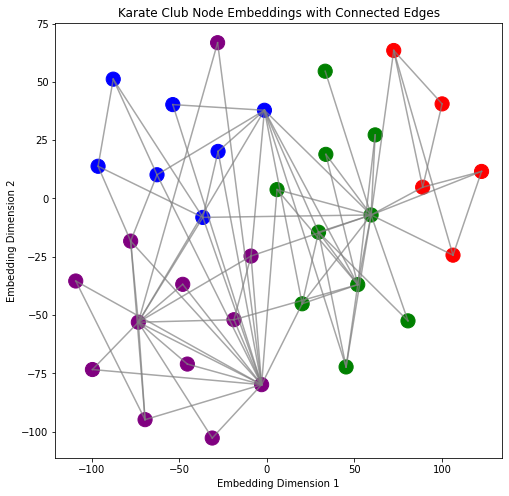

In [190]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

pred = model(A, X).detach().numpy()
out = TSNE(n_components=2).fit_transform(pred)

plt.figure(figsize=(8, 8))
plt.scatter(out[:, 0], out[:, 1], c=node_color, s=200)

for edge in edge_list:
    plt.plot(out[edge, 0], out[edge, 1], c='gray', alpha=0.7)

plt.title("Karate Club Node Embeddings with Connected Edges")
plt.xlabel("Embedding Dimension 1")
plt.ylabel("Embedding Dimension 2")
plt.show()

## 3. GAT

In [203]:
class GraphAttentionLayer(nn.Module):
    """
    Simple GAT layer, similar to https://arxiv.org/abs/1710.10903
    """

    def __init__(self, in_features, out_features):
        super(GraphAttentionLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features

        self.W = nn.Parameter(torch.randn((in_features, out_features)))
        self.a = nn.Parameter(torch.randn((2*out_features, 1)))
        self.leakyrelu = nn.LeakyReLU(0.05) # leaky relu has a hyper param

    def forward(self, adj, X):
        h = torch.mm(X, self.W)
        N = h.size()[0]

        a_input = torch.concat([h.unsqueeze(1).repeat(1, N, 1), h.unsqueeze(0).repeat(N, 1, 1)], 2)
        e = self.leakyrelu(torch.matmul(a_input, self.a).squeeze(2))

        zero_vec = -1e15*torch.ones_like(e)
        attention = torch.where(adj > 0, e, zero_vec)
        attention = F.softmax(attention, dim=1)
        h_prime = torch.matmul(attention, h)
        return h_prime
    
        
class GAT(nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes=4):
        super(GAT, self).__init__()
        self.layer1 = GraphAttentionLayer(num_features, hidden_dim)
        self.layer2 = GraphAttentionLayer(hidden_dim, num_classes)

    def forward(self, adjacency_matrix, features):
        h = F.relu(self.layer1(adjacency_matrix, features))
        output = self.layer2(adjacency_matrix, h)
        return output

model = GAT(34, 64)

### training and evaluation

In [204]:
from sklearn.metrics import accuracy_score

# define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-1) # lr is the learning rate

for epoch in range(501):
    """ model training """
    model.train()
    pred = model(A, X)
    # get the parts of training nodes
    loss = criterion(pred[train_nodes], Label[train_nodes])
    
    optimizer.zero_grad()
    loss.backward() 
    optimizer.step() 
    
    """ model evaluation """
    model.eval()
    with torch.no_grad():
        acc = accuracy_score(torch.max(pred[test_nodes], 1)[1], Label[test_nodes]) 
    
    if epoch % 20 == 0:
        print (f"{epoch}-th, train loss: {loss.item()}, test acc: {acc}")

0-th, train loss: 6.484377861022949, test acc: 0.11538461538461539
20-th, train loss: 0.917482316493988, test acc: 0.23076923076923078
40-th, train loss: 0.2766150236129761, test acc: 0.5769230769230769
60-th, train loss: 0.19134917855262756, test acc: 0.6153846153846154
80-th, train loss: 0.18114230036735535, test acc: 0.6153846153846154
100-th, train loss: 0.1787969470024109, test acc: 0.6153846153846154
120-th, train loss: 0.1780613362789154, test acc: 0.6153846153846154
140-th, train loss: 0.1777244657278061, test acc: 0.6153846153846154
160-th, train loss: 0.17740961909294128, test acc: 0.6923076923076923
180-th, train loss: 0.1770830601453781, test acc: 0.6923076923076923
200-th, train loss: 0.17482280731201172, test acc: 0.6538461538461539
220-th, train loss: 0.07577415555715561, test acc: 0.7307692307692307
240-th, train loss: 0.016124820336699486, test acc: 0.8076923076923077
260-th, train loss: 0.008581588044762611, test acc: 0.8076923076923077
280-th, train loss: 0.005900511

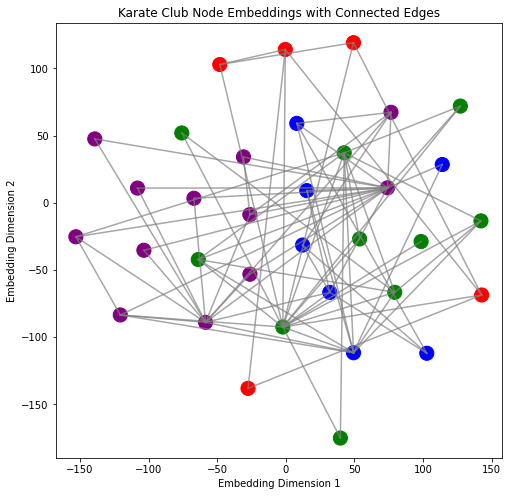

In [205]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

pred = model(A, X).detach().numpy()
out = TSNE(n_components=2).fit_transform(pred)

plt.figure(figsize=(8, 8))
plt.scatter(out[:, 0], out[:, 1], c=node_color, s=200)

for edge in edge_list:
    plt.plot(out[edge, 0], out[edge, 1], c='gray', alpha=0.7)

plt.title("Karate Club Node Embeddings with Connected Edges")
plt.xlabel("Embedding Dimension 1")
plt.ylabel("Embedding Dimension 2")
plt.show()

## 3. MPNN

In [196]:
class MessagePassingLayer(nn.Module):
    """
    Simple GAT layer, similar to https://arxiv.org/abs/1710.10903
    """

    def __init__(self, in_features, out_features):
        super(MessagePassingLayer, self).__init__()
        self.message_passing = nn.Linear(2 * in_features, out_features)
        self.read_out = nn.Linear(out_features, out_features)

    def forward(self, adj, X):
        N, _ = X.shape
        Z = torch.concat([X.unsqueeze(1).repeat(1, N, 1), X.unsqueeze(0).repeat(N, 1, 1)], 2)
        Z = self.message_passing(Z)
        Z = torch.einsum("abc,ad->dbc", Z, adj)
        Z = Z[torch.arange(N), torch.arange(N)]
        H = self.read_out(torch.relu(Z))
        return H
    
        
class MPNN(nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes=4):
        super(MPNN, self).__init__()
        self.layer1 = MessagePassingLayer(num_features, hidden_dim)
        self.layer2 = MessagePassingLayer(hidden_dim, num_classes)

    def forward(self, adjacency_matrix, features):
        h = F.relu(self.layer1(adjacency_matrix, features))
        output = self.layer2(adjacency_matrix, h)
        return output

model = MPNN(34, 64)

### training and evaluation

In [197]:
from sklearn.metrics import accuracy_score

# define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-1) # lr is the learning rate

for epoch in range(501):
    """ model training """
    model.train()
    pred = model(A, X)
    # get the parts of training nodes
    loss = criterion(pred[train_nodes], Label[train_nodes])
    
    optimizer.zero_grad()
    loss.backward() 
    optimizer.step() 
    
    """ model evaluation """
    model.eval()
    with torch.no_grad():
        acc = accuracy_score(torch.max(pred[test_nodes], 1)[1], Label[test_nodes]) 
    
    if epoch % 20 == 0:
        print (f"{epoch}-th, train loss: {loss.item()}, test acc: {acc}")

0-th, train loss: 1.3879894018173218, test acc: 0.34615384615384615
20-th, train loss: 0.40186449885368347, test acc: 0.7307692307692307
40-th, train loss: 0.19383007287979126, test acc: 0.8076923076923077
60-th, train loss: 0.14796452224254608, test acc: 0.8076923076923077
80-th, train loss: 0.11632770299911499, test acc: 0.8076923076923077
100-th, train loss: 0.09384135901927948, test acc: 0.8076923076923077
120-th, train loss: 0.07752491533756256, test acc: 0.8076923076923077
140-th, train loss: 0.06543903052806854, test acc: 0.8076923076923077
160-th, train loss: 0.056297339498996735, test acc: 0.8076923076923077
180-th, train loss: 0.04922232776880264, test acc: 0.7692307692307693
200-th, train loss: 0.04392293840646744, test acc: 0.7307692307692307
220-th, train loss: 0.039267636835575104, test acc: 0.7307692307692307
240-th, train loss: 0.035505764186382294, test acc: 0.7692307692307693
260-th, train loss: 0.03269822895526886, test acc: 0.7307692307692307
280-th, train loss: 0.0

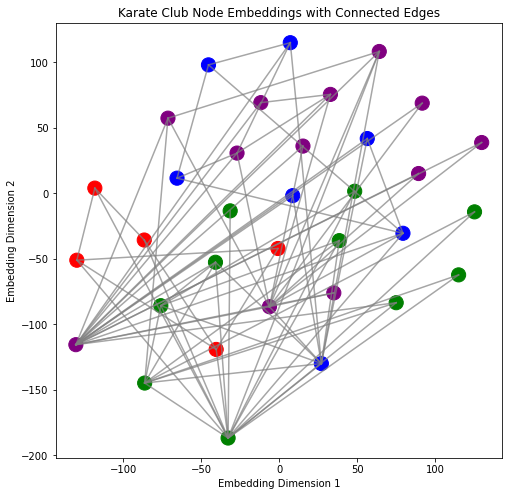

In [198]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

pred = model(A, X).detach().numpy()
out = TSNE(n_components=2).fit_transform(pred)

plt.figure(figsize=(8, 8))
plt.scatter(out[:, 0], out[:, 1], c=node_color, s=200)

for edge in edge_list:
    plt.plot(out[edge, 0], out[edge, 1], c='gray', alpha=0.7)

plt.title("Karate Club Node Embeddings with Connected Edges")
plt.xlabel("Embedding Dimension 1")
plt.ylabel("Embedding Dimension 2")
plt.show()